# Auto Regression

These are time series models built for forecasting via extrapolation instead interpolation.

This method can be ideal when trends are scaling over time. For example, a decision tree would be limited by the ranges of training data it has. 
<br>It would not be able to properly handle linear trends proceeding outside of its training data, since it often utilizes the mean.

The only required data is a datetime index and a value's historic data.
<br>There are no additional features.

Forecasts are based on the assumption that previous data has an affect on the current/future value.

### Types of Auto Regressors
<ol>
    <li>AR - Auto Regressive (Prediction from the values of all preceeding time periods)</li>
    <li>MA - Moving Average (Prediction from the value of a single time period)</li>
    <li>ARIMA - AR + MA + differencing</li>
    <li>SARIMA - ARIMA + seasonality</li>
</ol>

### Limitations
The limitations of these models are the following...
<ol>
    <li>Requires Stationarity.</li>
    <li>Can only work on one seasonal pattern.</li>
</ol>

To which our data unfortunately violates, as seasonality is the main concern with repeating 20 hour, weekly, monthly, and yearly seasons.

### Notebook Readme
SARIMA and TBATS take a long time to fit.

TBATS models were saved and loaded instead, while SARIMA has to be fit again because it's too large for github (>100 mb)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

# TIME PERIOD CORRELATION PLOTS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# MODELS
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from tbats import TBATS

import warnings
warnings.filterwarnings("ignore")

from joblib import dump, load

### Try it on the North Ave dataset

In [2]:
df = pd.read_csv('Knn Imputed/North Ave.csv')
df.index = pd.to_datetime(df['Date_Time'])
entries = df['Entry']

### Train Test Split
Do a simple 20% test size split.

We will attempt forecasting the last year.

In [3]:
train_size = 0.8
split_date = df.index[int(len(df) * 0.8)]

From:	 2022-04-18 04:00:00
To:	 2023-12-31 23:00:00


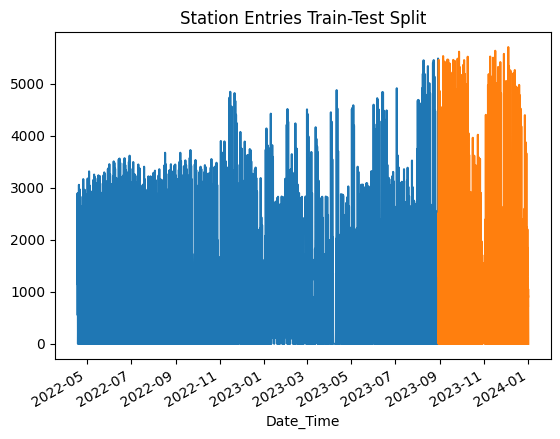

In [4]:
entries[:split_date].plot()
entries[split_date:].plot()

print('From:\t', entries.index[0])
print('To:\t', entries.index[-1])

plt.title('Station Entries Train-Test Split')
plt.show()

### Daily Period = 20 hours per day

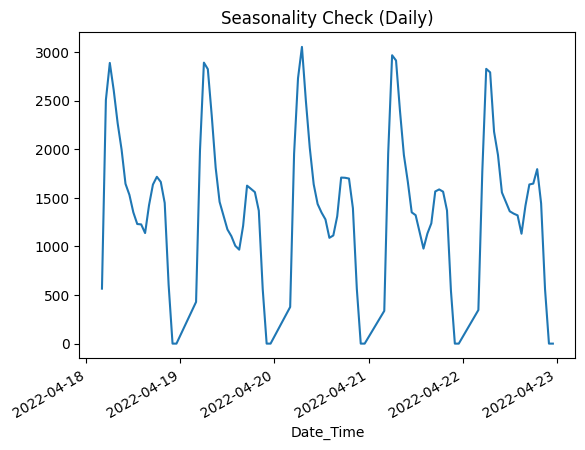

In [5]:
PERIOD = 20

entries[:20*5].plot()
plt.title('Seasonality Check (Daily)')
plt.show()

### Seasonality also observed in ACF

> Spikes around every 20th lag.
> 
> Repeating wave pattern.

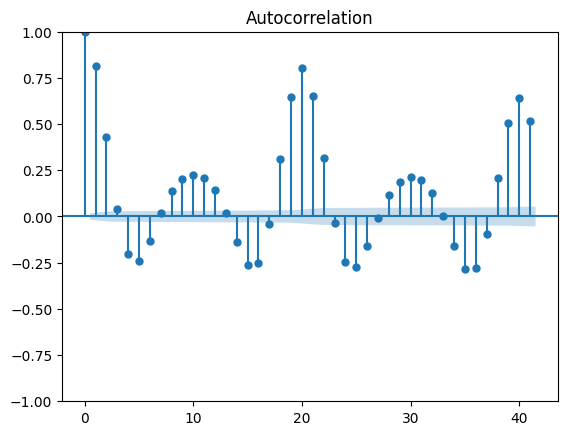

In [6]:
acf_plot = plot_acf(entries)

# Stationarity
> Removing seasonality and trends for better predictions.

Criterion:
<ol>
    <li>Constant mean</li>
    <li>Constant variance</li>
    <li>No seasonality</li>
</ol>
<i>Seasonality are patterns occuring within periods not exceeding the length of a year. Cycles are those patterns occur through multiple years.</i>

### Visual Method
#### ACF
ACF determines the correlation of all time periods between time start and end. 
<center>Ex. Correlation of the values of all the days from last Mon to this Mon</center>
MA can be retrieved from a significant spike MA(lag_number).
<br>AR(0) when ACF is exponentially decreasing.

#### PACF
PACF determines the correlation of only the start and time period.
<center>Ex. Correlation of the value in last Mon vs the value this Mon</center>
AR can be retrieved from a significant spike AR(lag_number). 
<br>MA(0) when PACF is exponentially decreasing.

### Analytical Method
An analytical method to determine stationarity is when using the ADFuller.
> When `pvalue` < 0.05, then there's no stationarity/unit root;<br>
> More negative `test_statistic` is more evidence of stationarity.

In [7]:
def ADF_Testing(values):
    labels = [
        'adf',
        'pvalue',
        'usedlag',
        'nobs'
        'critical values',
        'icbest',
        'resstore']

    return dict(zip(labels, adfuller(values)))

In [8]:
ADF_Testing(entries)

{'adf': -11.081039902546829,
 'pvalue': 4.310722932996342e-20,
 'usedlag': 41,
 'nobscritical values': 12418,
 'icbest': {'1%': -3.4308767073814277,
  '5%': -2.861772778323106,
  '10%': -2.5668939028993316},
 'resstore': 174674.1225986731}

### Default ADF Scores
The ADF scores seemingly indicate that there's stationarity from the **pvalue < 0.5** and **negative adf**.

However, consider that we're using only 41 lags. That's not enough to make a proper judgement for 20 hour periods.

We could use `usedlag=PERIOD * 40`, but that would take too long to compute.

Hence visual plotting can be the better approach.

### Eliminating Seasonality

#### Differencing by the seasonal period of 20 hours, should remove daily seasonality.

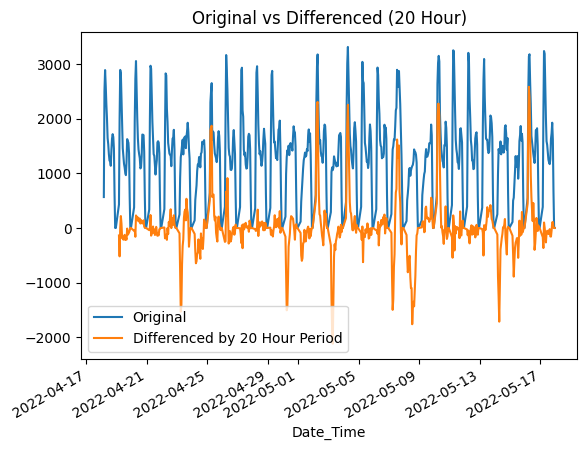

In [9]:
entries_seasonal = entries.diff(PERIOD)

LIMIT = PERIOD*30

entries[:LIMIT].plot()
entries_seasonal[:LIMIT].plot()
plt.legend(['Original', 'Differenced by 20 Hour Period'])
plt.title('Original vs Differenced (20 Hour)')
plt.show()

### We still see spikes.
#### We can try differencing again by the weekly period (7), yet results don't seem to improve.

<Axes: xlabel='Date_Time'>

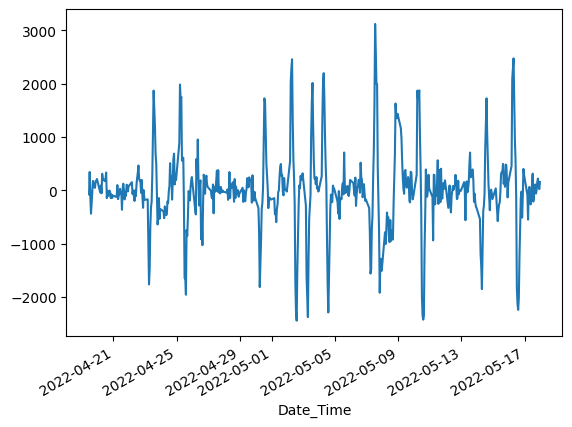

In [10]:
entries_seasonal.diff(7)[:LIMIT].plot()

### The more differencing we perform, the closer we get to stationarity. 
The ADF has a more negative value and near zero pvalue.

Let's proceed with only the diff(20), and see how it performs.

In [11]:
ADF_Testing(entries_seasonal.dropna())

{'adf': -21.783949123547465,
 'pvalue': 0.0,
 'usedlag': 41,
 'nobscritical values': 12398,
 'icbest': {'1%': -3.4308775572225216,
  '5%': -2.8617731538770115,
  '10%': -2.566894102804388},
 'resstore': 175397.53090687227}

### Selecting parameters: order(p, d, q)

> p - AR. Lag determined from the PACF.
>
> d - Integrated. Number of times difference operations performed
> 
> q - MA. Lag determined from the ACF

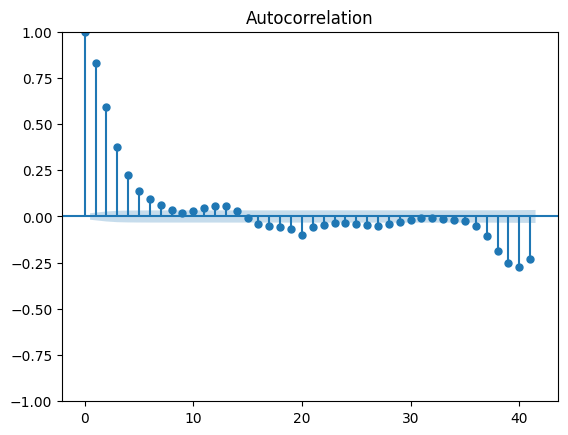

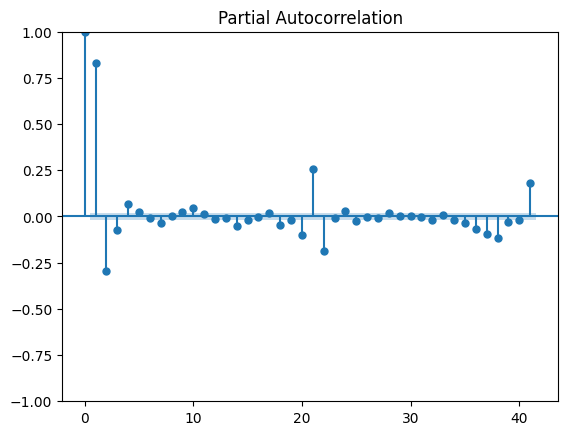

In [12]:
plots = [
    plot_acf(entries_seasonal.dropna()),
    plot_pacf(entries_seasonal.dropna())
]

### AR(2) and MA(0)
The ACF is exponentially decreasing hence we could try MA(0).

Meanwhile PACF shows a spike at lag 2, so let's try AR(2).

In [13]:
def get_Forecast_Results(model, title, LIMIT=1000, is_Numpy = True):
    df = pd.DataFrame(entries_seasonal[split_date:])
    if is_Numpy:
        df[title] = model.forecast(len(entries_seasonal[split_date:])).values
    else:
        df[title] = model.forecast(len(entries_seasonal[split_date:]))
    
    df[:LIMIT].plot()
    plt.title(title)
    plt.show()

# ARIMA
The standard ARIMA model is not built for seasonal data.

Nonetheless, let's see its forecasts for comparisson.

In [14]:
# Intentionally used d=0, to at least some variation than just 0 forecasts
model_ARIMA = ARIMA(entries_seasonal[:split_date].dropna(), order=(2,0,0)).fit()

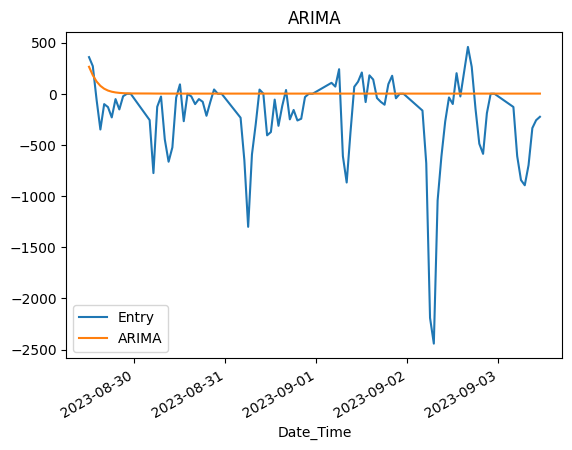

In [15]:
get_Forecast_Results(model_ARIMA, 'ARIMA', 100)

#### ARIMA Results
We see it simply flat line.

It didn't capture any sort of pattern at all.

# SARIMA
SARIMA introduces an additional `seasonal_order` hyperparameter.

This is similar to `order` but has the additional `period`.

In [16]:
model_SARIMAX = sm.tsa.statespace.SARIMAX(entries_seasonal[:split_date].dropna(), order=(2,1,0), seasonal_order=(2,1,0,20)).fit()

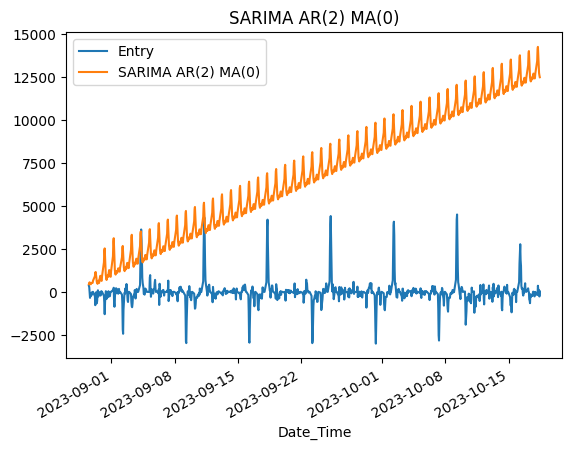

In [17]:
get_Forecast_Results(model_SARIMAX, 'SARIMA AR(2) MA(0)', 1000)

#### SARIMA Results
It seems to have captured some sort of pattern but the Moving Average is clearly wrong as it's trending upwards.

## Can AUTO SARIMA do better?
Takes too long to fit    
'''
    
    model_auto_SARIMA = auto_arima(entries_seasonal[:1000].dropna(), m=PERIOD, seasonal=True)
    get_Forecast_Results(model_SARIMAX, 'Auto SARIMA', 1000)
'''

Try, incrementing MA instead.

In [18]:
model_SARIMAX = sm.tsa.statespace.SARIMAX(entries_seasonal[:split_date].dropna(), order=(2,1,1), seasonal_order=(2,1,1,20)).fit()

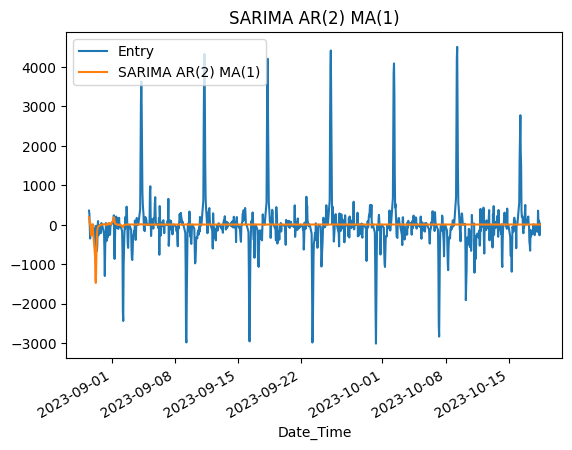

In [19]:
get_Forecast_Results(model_SARIMAX, 'SARIMA AR(2) MA(1)', 1000)

#### Different SARIMA Results
Although we could try different order combinations, the problem still lies in the multiple different seasonalities present.

As mentioned in the start, SARIMA can only operate on one seasonal period, yet we have a weekly pattern still and possibly monthly and yearly.

## Attempt daily forecast instead

In order to try and remove the pattern from hours, let's do use days instead of hours.

#### Total entries per day

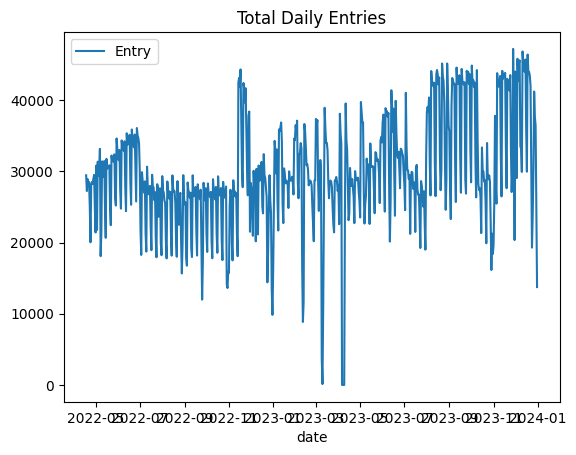

In [20]:
df['date'] = df.index.date

daily_entries = df[['date', 'Entry']].groupby('date').sum()
daily_entries.plot()
plt.title("Total Daily Entries")
plt.show()

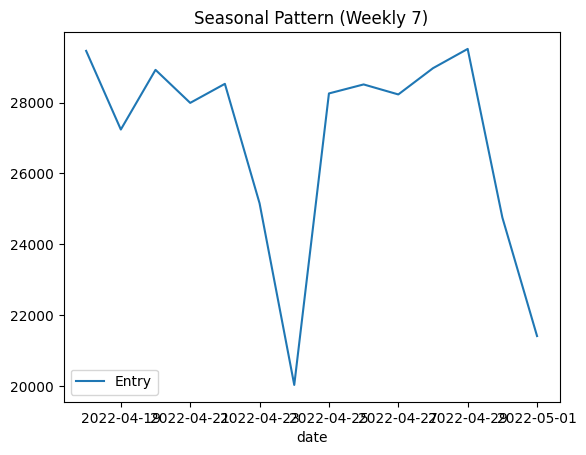

In [21]:
daily_entries[:7*2].plot()
plt.title("Seasonal Pattern (Weekly 7)")
plt.show()

#### Verify with spikes around lag 7

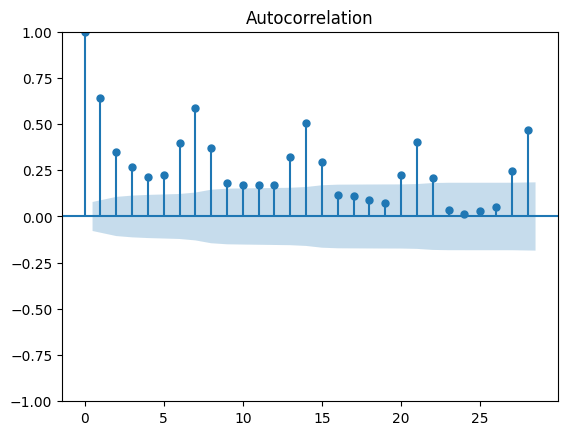

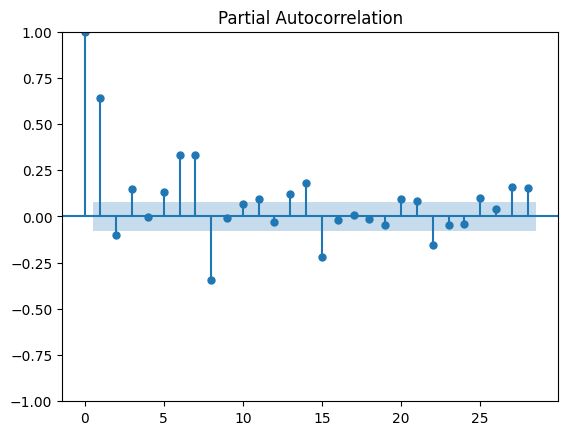

In [22]:
a = plot_acf(daily_entries)
b = plot_pacf(daily_entries)

## Removing weekly seasonality 
Difference by 7 periods

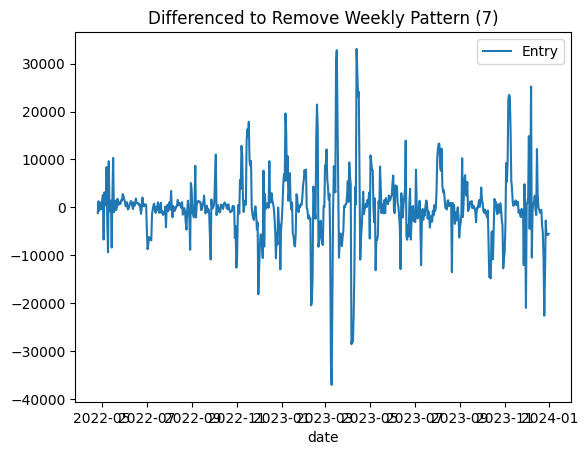

In [23]:
daily_entries_seasonal = daily_entries.diff(7)
daily_entries_seasonal.plot()
plt.title('Differenced to Remove Weekly Pattern (7)')
plt.show()

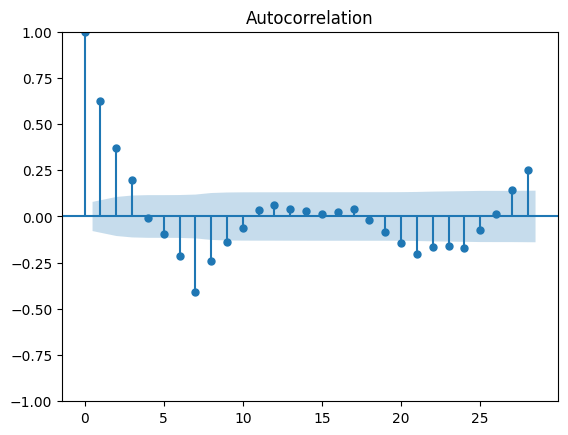

In [24]:
a = plot_acf(daily_entries_seasonal.dropna())

### There's still a seasonal pattern with wave like pattern.
Unfortunately we're still not able to completely remove seasonality, hence SARIMA would not work well.

# TBATS
To deal with multiple seasonalities let's attempt calling TBATS instead.

It's able to automatically handle our challenges and produce better results.

Overall let's try telling it to run different seasonal_periods
<li>(20)</li>
<li>(20, 7)</li>
<li>(20, 7, 4.34)</li>
<li>(20, 7, 4.34, 12)</li>
<li>(hours in a day, days in a week, weeks in a month, months in a year)</li>

'''

    TBATS(seasonal_periods=[20, 7, 4.34, 12]).fit(entries[split_date:].dropna())
'''

Takes too long to run again. Just load the model instead

In [25]:
# model_TBATS = TBATS(seasonal_periods=[20, 7, 12]).fit(entries[split_date:].dropna())

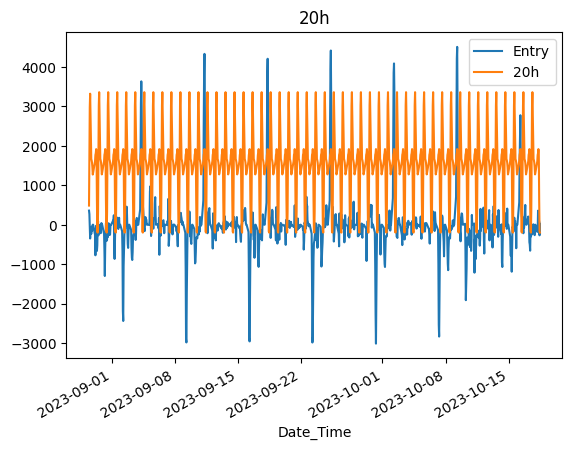

In [26]:
get_Forecast_Results(load('Models/ARIMA/TBAT_20.model'), '20h', 1000, False)

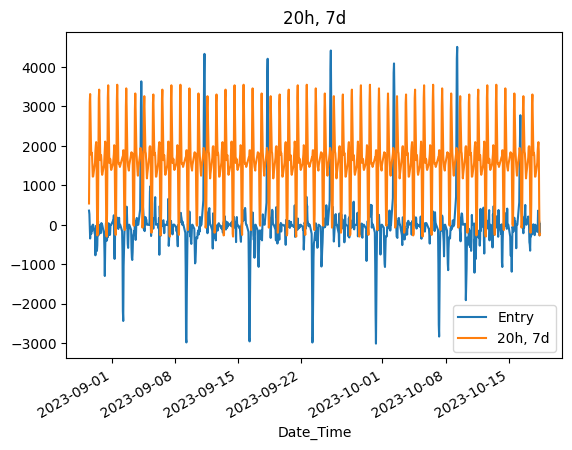

In [27]:
get_Forecast_Results(load('Models/ARIMA/TBAT_20_7.model'), '20h, 7d', 1000, False)

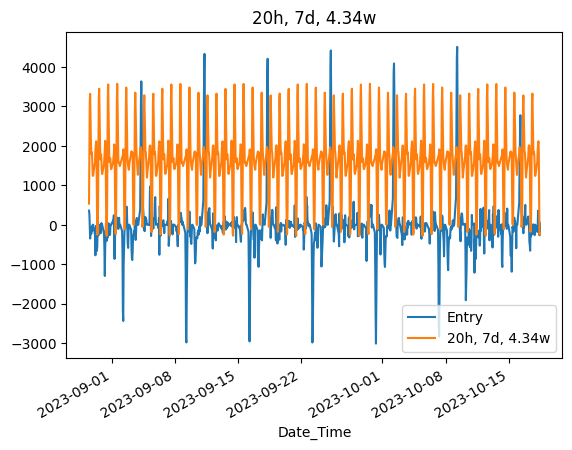

In [28]:
get_Forecast_Results(load('Models/ARIMA/TBAT_20_7_4.model'), '20h, 7d, 4.34w', 1000, False)

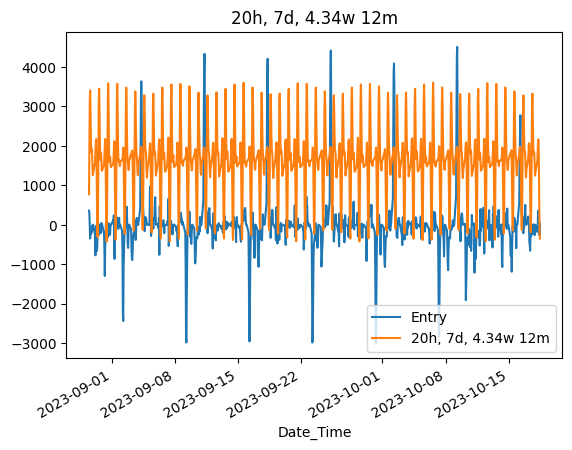

In [29]:
get_Forecast_Results(load('Models/ARIMA/TBAT_20_7_4_12.model'), '20h, 7d, 4.34w 12m', 1000, False)

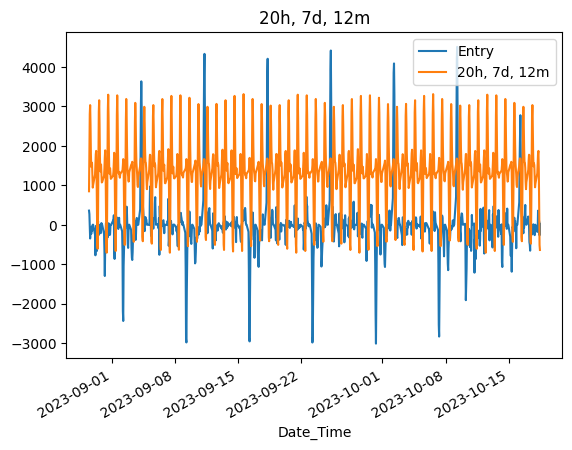

In [30]:
get_Forecast_Results(load('Models/ARIMA/TBAT_20_7_12.model'), '20h, 7d, 12m', 1000, False)

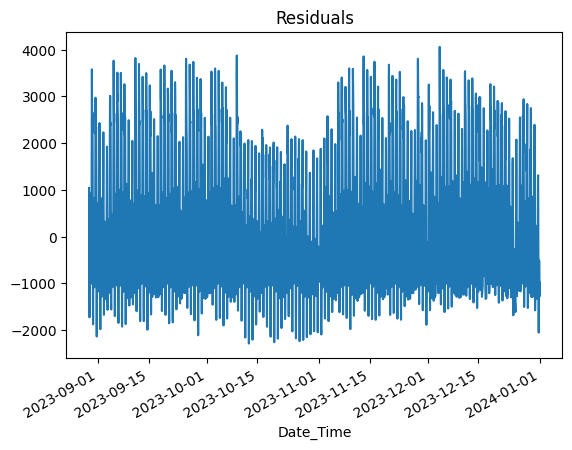

In [31]:
best_TBAT = load('Models/ARIMA/TBAT_20_7_12.model')

(entries[split_date:] - best_TBAT.forecast(len(entries[split_date:]))).plot()
plt.title('Residuals')
plt.show()

## TBATS results
Among trying different combinations of seasonalities, the best results was 

> 20 hours, 7 days, 12 months

Adding more seasonalities after the 20h, tends to better capture the shape.

However all TBAT models are still overforecasting and unsurprisingly leave high residuals.

# Summary

Seasonailty is the major challenged faced in these models as differncing alone wasn't able to remove all seasonal patterns.

SARIMA could only handle 1 seasonal pattern, while TBATS can handle more combinations.

The best result of which was for (20h, 7d, 12m) but they were still poor forecasts.

### Recommendation
We could try the **rolling window approach** or **timeseriessplit cross validation** but with how poor the results currently are and the time required to fit TBATS, it would be quite the hassle.